## Predicated range delay from troposphere based on ERA5

+ ERA5
  - 0.25 deg spatial resolution
  - 1-hour temporal resolution


+ reference geometry:
  - use incidence angle, latitude and longitude of the scene center
  - use terrain height for vertical integration.


+ tropospheric components:
  - Dry troposphere: large absolute value with little variation
  - Wet troposphere: small absolute value with large  variation
  - comb (dry + wet) delay is used.

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp, isce_utils
from mintpy import tropo_pyaps3, view
import pyaps3 as pa
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]


##### setup
win = 5  # half size of the window of interest
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

##### initiation
proj_name = 'SenDT156'  # SenAT149, SenDT156
proj_dir = os.path.join('/Users/yunjunz/data/Tarapaca', proj_name)
os.chdir(proj_dir)
print('Go to directory', proj_dir)

out_file = os.path.join(proj_dir, 'offset_comp', box_suffix ,'era5.pickle')

Go to directory /Users/yunjunz/data/Tarapaca/SenDT156


### 1. calc tropo delay based on `terrain height` and `real DEM`

In [2]:
# required input files
ts_files = [
    os.path.join(proj_dir, 'mintpyOffset/inputs/ERA5.h5'),
    os.path.join(proj_dir, 'mintpyOffset/inputs/ERA5_dry.h5'),
    os.path.join(proj_dir, 'mintpyOffset/inputs/ERA5_wet.h5'),
]
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')

# get terrain height
xml_file = os.path.join(proj_dir, 'reference/IW1.xml')
burst = isce_utils.extract_isce_metadata(xml_file)[1]
print('terrain height: {} m'.format(burst.terrainHeight))

# calculate absolute tropospheric delay from ERA5
delay_types = ['comb', 'dry', 'wet']
for i in range(len(ts_files)):
    ts_file = ts_files[i]
    if not os.path.isfile(ts_file):
        sar_file = os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5')
        iargs = ['-f', sar_file,
                 '-g', geom_file,
                 '--delay', delay_types[i],
                 '--tropo-file', ts_file]
        print('tropo_pyaps3.py', ' '.join(iargs))
        tropo_pyaps3.main(iargs)
    else:
        print('file already exists: {}'.format(ts_files[i]))
print('Done.')

# plot the real DEM for reference
#view.main([geom_file, 'height', '--zero-mask'])

extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/Tarapaca/SenDT156/reference/IW1.xml
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
terrain height: 4037.989153916667 m
file already exists: /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/ERA5.h5
file already exists: /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/ERA5_dry.h5
file already exists: /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/ERA5_wet.h5
Done.


### 2. save to pickle file

In [3]:
# lalo --> box
atr = readfile.read_attribute(ts_files[0])
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')
coord = ut.coordinate(atr, lookup_file=geom_file)
y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
box = (x-win, y-win, x+win, y+win)

# read data
date_list = timeseries(ts_files[0]).get_date_list()
num_date = len(date_list)
ts_data_list = []
for ts_file in ts_files:
    ts_data = readfile.read(ts_file, box=box)[0].reshape(num_date, -1)
    # exclude pixels with no-valid data
    ts_data[ts_data == 0] = np.nan
    # reverse back the sign because it was reversed in tropo_pyaps3.py#L584
    ts_data *= -1
    ts_data_list.append(ts_data)

# calculate median and mean
## compose off dict
tropo = {}
tropo['date'] = np.array(date_list)
tropo['time'] = np.array(ptime.date_list2vector(date_list)[0])
tropo['range_delay_tropo_med']     = np.nanmedian(ts_data_list[0], axis=-1)
tropo['range_delay_tropo_med_dry'] = np.nanmedian(ts_data_list[1], axis=-1)
tropo['range_delay_tropo_med_wet'] = np.nanmedian(ts_data_list[2], axis=-1)
tropo['range_delay_tropo_mad']     = ut.median_abs_deviation(ts_data_list[0])
tropo['range_delay_tropo_mad_dry'] = ut.median_abs_deviation(ts_data_list[1])
tropo['range_delay_tropo_mad_wet'] = ut.median_abs_deviation(ts_data_list[2])

## save off dict to pickle file
os.makedirs(os.path.dirname(out_file), exist_ok=True)
with open(out_file, 'wb') as f:
    pickle.dump(tropo, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/Tarapaca/SenDT156/offset_comp/boxLR/era5.pickle


### 3. plot (variation between dry and wet troposphere)

save figure to file /Users/yunjunz/data/Tarapaca/SenDT156/offset_comp/boxLR/era5.png


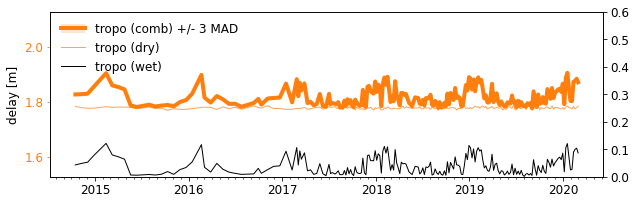

In [4]:
key_base = 'range_delay_tropo'
n = 3

x = tropo['time']
y0 = tropo[key_base+'_med']
y1 = tropo[key_base+'_med_dry']
y2 = tropo[key_base+'_med_wet']
y0_err = tropo[key_base+'_mad'] * n
y1_err = tropo[key_base+'_mad_dry'] * n
y2_err = tropo[key_base+'_mad_wet'] * n

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, sharex=True)
# axis 1
p2, = ax.plot(x, y1, '-', linewidth=1, color='C1', alpha=0.7)
p0, = ax.plot(x, y0, '-', linewidth=4, color='C1')
p1  = ax.fill_between(x, y0 - y0_err, y0 + y0_err, fc='C1', ec='none', alpha=0.2)

# axis 1 format
ax.tick_params(which='both', axis='y', colors='C1')
pp.auto_adjust_xaxis_date(ax, x, every_year=1, buffer_year=None)
ax.set_ylabel('delay [m]')

# axis 2
ax2 = ax.twinx()
p3, = ax2.plot(x, y2, '-', linewidth=1, color='k')
ax2.tick_params(which='both', axis='y', colors='k')

# auto ylim
ylim = ut.ceil_to_1(np.max(y0) - np.min(y0)) * 1.5
ylim = 0.3
ycen = np.mean(y1) + 0.05
ax.set_ylim(ycen-ylim, ycen+ylim)
ax2.set_ylim(0, ylim*2)

ax.legend([(p0, p1), p2, p3], ['tropo (comb) +/- {} MAD'.format(n), 
                               'tropo (dry)',
                               'tropo (wet)'],
         frameon=False, loc='upper left')
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'era5.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()